In [1]:
import os
from os.path import join
import glob
from itertools import compress
import numpy as np
import pandas as pd
import tensorflow as tf
import geopandas as gpd
import matplotlib.pyplot as plt
import logging

# helper functions
from importlib import reload
import model_utils
import viz_utils

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# create logging to file
logdir = join("logfiles")
logger = logging.getLogger("scnn")
logger.setLevel(logging.INFO)
fh = logging.FileHandler(join(logdir, "scnn.log"), mode='a')
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s, %(levelname)s: %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

# settings
viz = False
storm = ""  # e.g., "roanu" or "" for all events
temporal = False
binary = True
features = ['elevation', 'jrc_permwa', 'precip', 'ndvi',
            'soilcarbon', 'dist_pw', 'slope_pw', 'aqueduct']

# set up the environment
wd = join("..", "data")
imdir = join(wd, 'images')
resultsdir = join(wd, 'results')

#### Use this cell to get landfall times to add to current_dataset.csv
    # if multiple landfalls use NOAA's historical hurricane tracks to see which makes more sense
    # take first entry that has 0 and copy+paste into current datasets

    pd.set_option('display.max_rows', None)

    storm = "molave"

    ibtracs = pd.read_csv(join(wd, 'ibtracs_last3years.csv'))[['NAME', 'ISO_TIME', 'LANDFALL', 'DIST2LAND']]
    ibtracs = ibtracs[ibtracs.NAME == storm.upper()].replace(' ', np.nan)
    min_landfall = int(ibtracs.LANDFALL.astype(float).min())
    print(f"min: {min_landfall}")
    ibtracs[ibtracs.LANDFALL == str(min_landfall)]

In [2]:
# load the GeoDataFrame
reload(model_utils)
gdf, features = model_utils.get_data(wd, features, temporal, binary, storm)
nfeatures = len(features)

print("Number of unique images (i.e., subregions):", gdf['event'].nunique())

Number of storms: 9
Number of regions: 19

Binarising floodfrac...

Number of unique images (i.e., subregions): 30


In [3]:
# calculate quantities of data for loss function
n = len(gdf)
n1 = gdf['floodfrac'].sum()
n0 = n - n1
print("Zeros:", n0)
print("Ones:", n1)
print(f"Null values: {sum(gdf.isnull().any())}")

Zeros: 117930
Ones: 4950
Null values: 0


In [4]:
# reformat into numpy arrays for tensorflow
Xmats = []
ymats = []

# now calculate X and y matrices
for event in [*gdf['event'].unique()]:
    temp = gdf[gdf.event==str(event)]
    if len(temp) > 0:
        Xmat, ymat, feature_key = model_utils.get_matrices(temp, 500, features)
        Xmats.append(Xmat)
        ymats.append(ymat)
        
feature_key_r = {item: key for key, item in feature_key.items()}

# calculate weights and flatten labels matrix
ymats_bool = [mat.astype(bool) for mat in ymats]
ymats_flat = [mat.flatten() for mat in ymats]
ymats_flat = [np.expand_dims(mat, -1) for mat in ymats_flat]

In [5]:
# create TensorFlow datasets with batch size 1 (since small dataset)
n = len(Xmats)
ntrain = int(0.6 * n)
ntest = int(0.2 * n)

# create dataset
data = tf.data.Dataset.from_tensor_slices((Xmats, ymats_flat)).batch(1)
train = data.take(ntrain)
test = data.skip(ntrain)
valid = test.skip(ntest)
test = test.take(ntest)

# extract matrices from train for visualisation later
X_train = [element[0].numpy()[0, :, :, :] for element in train]
X_valid = [element[0].numpy()[0, :, :, :] for element in valid]
X_test = [element[0].numpy()[0, :, :, :] for element in test]

y_train = [element[1].numpy()[0, :] for element in train]
y_valid = [element[1].numpy()[0, :] for element in valid]
y_test = [element[1].numpy()[0, :] for element in test]

print("Dataset size:", n)
print("Training size:", len(X_train))
print("Validation size:", len(X_valid))
print("Test size:", len(X_test))

Dataset size: 30
Training size: 18
Validation size: 6
Test size: 6


### Weighting options

In [6]:
def add_sample_weights(image, label):
    """Add sample weights."""
    class_weights = tf.constant(weights_list)  # global var
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))
    return image, label, sample_weights

def add_pw_weights(image, label):
    """Add weights for permanent water."""
    class_weights = tf.constant([0.0, 1.0])
    pw = image[0, :, :, 1]
    pw = tf.reshape(pw, [1, 64 * 64, 1])
    land_mask = pw < 50
    sample_weights = tf.gather(class_weights, indices=tf.cast(land_mask, tf.int32))
    return image, label, sample_weights

def add_both_weights(image, label):
    """Add both sample and permanent water weights."""
    class_weights = tf.constant(weights_list)  # global var

    # create a permanent water mask (assuming pw feature in channel 1)
    pw = image[0, :, :, 1]
    pw = tf.reshape(pw, [1, 64 * 64, 1])
    land_mask = pw < 50
    land_mask = tf.cast(land_mask, dtype=tf.float32)
    
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))
    sample_weights *= land_mask

    return image, label, sample_weights

In [7]:
viz = False

weights_list = [0.1, 0.9]

if viz:
    # sample weights
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    for element in train.map(add_sample_weights).take(1):
        im0 = ax[0].imshow(element[1][0, :, :].numpy().reshape(64, 64), cmap="YlGnBu")
        ax[0].set_title("Flooding")
        im = ax[1].imshow(element[2][0, :, :].numpy().reshape(64, 64), cmap="Spectral_r")
        ax[1].set_title("Weighting")
    fig.colorbar(im0, ax=ax[0])
    fig.colorbar(im, ax=ax[1])
    
    
    # permanent water weights
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    for element in train.map(add_pw_weights).take(1):
        im0 = ax[0].imshow(element[1][0, :, :].numpy().reshape(64, 64), cmap="YlGnBu")
        ax[0].set_title("Flooding")
        im = ax[1].imshow(element[2][0, :, :].numpy().reshape(64, 64), cmap="Spectral_r")
        ax[1].set_title("Weighting")
    fig.colorbar(im0, ax=ax[0])
    fig.colorbar(im, ax=ax[1])
    
    # both weights
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    for element in train.map(add_both_weights).take(1):
        im0 = ax[0].imshow(element[1][0, :, :].numpy().reshape(64, 64), cmap="YlGnBu")
        ax[0].set_title("Flooding")
        im = ax[1].imshow(element[2][0, :, :].numpy().reshape(64, 64), cmap="Spectral_r")
        ax[1].set_title("Weighting")
    fig.colorbar(im0, ax=ax[0])
    fig.colorbar(im, ax=ax[1])

### Visualise train and test sets

In [8]:
vmins = []
vmaxs = []
for feature in features:
    vmins.append(gdf[feature].min())
    vmaxs.append(gdf[feature].max())

In [9]:
# view training set
viz = False

if viz:
    fig, ax = plt.subplots(nfeatures+1, len(y_train), figsize=(2 * len(y_train), 2 * nfeatures + 1))
    for i, im in enumerate(y_train):
        pos = ax[0, i].imshow(im.reshape(64, 64), cmap="YlGnBu")
        ax[0, 0].set_title(f"Flood Fraction")
    fig.colorbar(pos, ax=ax[0, len(y_train)-1])
        
    for fi in range(nfeatures):
        for i, im in enumerate(X_train):
            pos = ax[fi+1, i].imshow(im[:, :, fi], cmap=feature_cmaps[fi], vmin=vmins[fi], vmax=vmaxs[fi])
            ax[fi+1, 0].set_title(features[fi].capitalize())
        fig.colorbar(pos, ax=ax[fi+1, len(y_train)-1])

    plt.savefig(join(imdir, "trainingset_binary.png"), bbox_inches="tight")

In [10]:
# view testing set
viz = False

if viz:
        fig, ax = plt.subplots(nfeatures+1, len(y_test), figsize=(2 * len(y_test), 2 * nfeatures + 1))
        for i, im in enumerate(y_test):
            pos = ax[0, i].imshow(im.reshape(64, 64), cmap="YlGnBu")
            ax[0, i].set_xticks([])
            ax[0, i].set_yticks([])
            ax[0, 0].set_title(f"Flood Fraction")
        # fig.colorbar(pos, ax=ax[0, len(y_test)-1])

        for fi in range(nfeatures):
            for i, im in enumerate(X_test):
                pos = ax[fi+1, i].imshow(im[:, :, fi], cmap=feature_cmaps[fi]) # , vmin=vmins[fi], vmax=vmaxs[fi])
                ax[fi+1, 0].set_title(features[fi].capitalize())
                ax[fi+1, 0].set_xticks([])
                ax[fi+1, 0].set_yticks([])
            # fig.colorbar(pos, ax=ax[fi+1, len(y_test)-1])

        plt.savefig(join(imdir, "testingset_binary.png"), bbox_inches="tight")

### SCNN
Can either use:
1. A `BinaryCrossentropy` loss with the sigmoid activation function and no one-hot encoding. This requires the array to be flattened to shape ($x\times y$, nchannels).
2. A `SparseCategoricalCrossentropy` loss with a softmax activation function and one-hot encoding on the predictions only (i.e., labels are never one-hot encoded). This doesn't require the array to be flattened.

For model calibration, it may be preferable to use a bias measure instead since this would determine what parameter set provides the balance between over and underprediction, but while there may be binary pattern performance measures that do not show bias to either under or over prediction, they will still be affected by the magnitude effect mentioned below (Stephens 2014).

#### Model improvements:
1. [ ] Tuning
2. [ ] Loss function
3. [x] Metrics

In [56]:
# https://stackoverflow.com/questions/64805255/customized-loss-function-in-keras-iou-loss-function-and-gradient-error 

def BinaryIoU_loss(y_true, y_pred, target_class=1):
    # shape (64 * 64, 1)
    true_labels = K.equal(y_true, target_class)
    pred_labels = K.equal(y_pred, target_class)

    inter = tf.cast(true_labels & pred_labels, dtype=tf.int32)
    union = tf.cast(true_labels | pred_labels, dtype=tf.int32)

    iou = K.sum(inter) / K.sum(union)
    return iou

In [57]:
y_true = [1, 0, 1]
y_pred = [0, 0, 1]

BinaryIoU_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.5>

In [15]:
import tensorflow as tf
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Reshape
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, concatenate
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanIoU, Recall
from tensorflow.keras import Model
from keras.losses import BinaryCrossentropy
from keras import backend as K


TP = tf.keras.metrics.TruePositives(name="TP")
TN = tf.keras.metrics.TrueNegatives(name="TN")
FP = tf.keras.metrics.FalsePositives(name="FP")
FN = tf.keras.metrics.FalseNegatives(name="FN")
CSI = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5, name="CSI")


# settings
k_init = "he_normal"
dilation_rate = (50, 50)  # (80, 80) => see shape of water in probs
weight_dry = 0.05
weights_list = [weight_dry, 1 - weight_dry]
weight_func =  add_sample_weights # [add_sample_weights, add_pw_weights, and add_both_weights]
optimizer = SGD(1e-3)
loss = CSI  # BinaryCrossentropy(from_logits=True)
metrics = [CSI, TP, FP, FN, TN]
epochs = 40
patience = 3

In [16]:
SEED = 1

np.random.seed(SEED)
tf.random.set_seed(SEED)

def build_scnn(shape=(128, 128, 3), k_init="he_normal", dilation_rate=(1, 1)):
    inputs = Input(shape=shape)
    normalized = BatchNormalization(axis=3)(inputs)
    
    x = Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=k_init)(normalized)
    x = Conv2D(128, 3, padding="same", activation="relu", dilation_rate=dilation_rate, kernel_initializer=k_init)(x)
    x = Conv2D(128, 3, padding="same", activation="relu", kernel_initializer=k_init)(x)
    
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x)
    outputs = Reshape((64 * 64, 1))(outputs)
    scnn = Model(inputs, outputs, name="SCNN")
    return scnn

scnn = build_scnn(shape=(64, 64, len(gdf[features].columns)),
                  k_init=k_init,
                  dilation_rate=dilation_rate)
scnn.summary()

scnn.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

history = scnn.fit(train.map(weight_func),
                   epochs=epochs,
                   validation_data=valid,
                   callbacks=EarlyStopping(patience=patience))

Model: "SCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 9)]       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 9)        36        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        5248      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 1)         129       
                                                              

ValueError: in user code:

    File "/Users/alisonpeard/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/Users/alisonpeard/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/alisonpeard/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/Users/alisonpeard/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/keras/engine/training.py", line 893, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/alisonpeard/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 539, in minimize
        return self.apply_gradients(grads_and_vars, name=name)
    File "/Users/alisonpeard/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 640, in apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    File "/Users/alisonpeard/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/utils.py", line 73, in filter_empty_gradients
        raise ValueError(f"No gradients provided for any variable: {variable}. "

    ValueError: No gradients provided for any variable: (['batch_normalization/gamma:0', 'batch_normalization/beta:0', 'conv2d/kernel:0', 'conv2d/bias:0', 'conv2d_1/kernel:0', 'conv2d_1/bias:0', 'conv2d_2/kernel:0', 'conv2d_2/bias:0', 'conv2d_3/kernel:0', 'conv2d_3/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'batch_normalization/gamma:0' shape=(9,) dtype=float32>), (None, <tf.Variable 'batch_normalization/beta:0' shape=(9,) dtype=float32>), (None, <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 9, 64) dtype=float32>), (None, <tf.Variable 'conv2d/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 64, 128) dtype=float32>), (None, <tf.Variable 'conv2d_1/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 128, 128) dtype=float32>), (None, <tf.Variable 'conv2d_2/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv2d_3/kernel:0' shape=(1, 1, 128, 1) dtype=float32>), (None, <tf.Variable 'conv2d_3/bias:0' shape=(1,) dtype=float32>)).


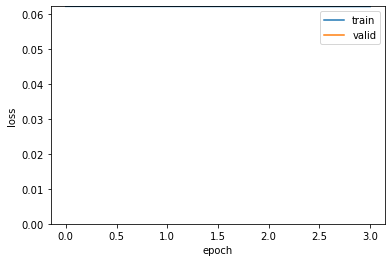

In [13]:
im = model_utils.plot_history(history, metric='loss')
plt.savefig(join(imdir, "scnn_training_loss.png"), bbox_inches="tight")

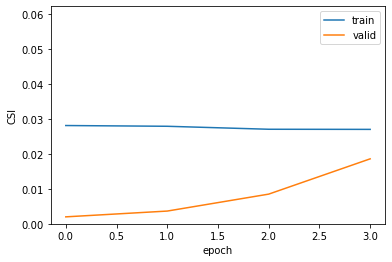

In [14]:
im = model_utils.plot_history(history, metric='CSI')
plt.savefig(join(imdir, "scnn_training_csi.png"), bbox_inches="tight")

In [15]:
y_probs = scnn.predict(test)
y_pred = (y_probs > 0.5).astype(float)

CSI.update_state(y_test, y_probs)
TP.update_state(y_test, y_probs)
FP.update_state(y_test, y_probs)
FN.update_state(y_test, y_probs)
TN.update_state(y_test, y_probs)

csi = CSI.result().numpy()
tp = TP.result().numpy()
fp = FP.result().numpy()
fn = FN.result().numpy()
tn = TN.result().numpy()

# assert 4096 * len(y_test) == tp + tn + fp + fn  # ????

print(f"CSI: {csi*100:.2f}%")
print(f"TP: {tp:.0f}")
print(f"FP: {fp:.0f}")
print(f"FN: {fn:.0f}")
print(f"TN: {tn:.0f}")

print(f"Bias: {(tp + fp) / (tp + fn) :.2f}")  # small=>underprediction
print(f"Hit rate: {tp /(tp + fn):.2f}")
print(f"False alarm rate: {fp / (fp + tn):.2f}")
print(f"F<3>: {(tp - fn) / (tp + fp + fn):.2f}")

6/6 [==============================] - 0s 17ms/step
CSI: 1.01%
TP: 32
FP: 1148
FN: 1994
TN: 45978
Bias: 0.58
Hit rate: 0.02
False alarm rate: 0.02
F<3>: -0.62


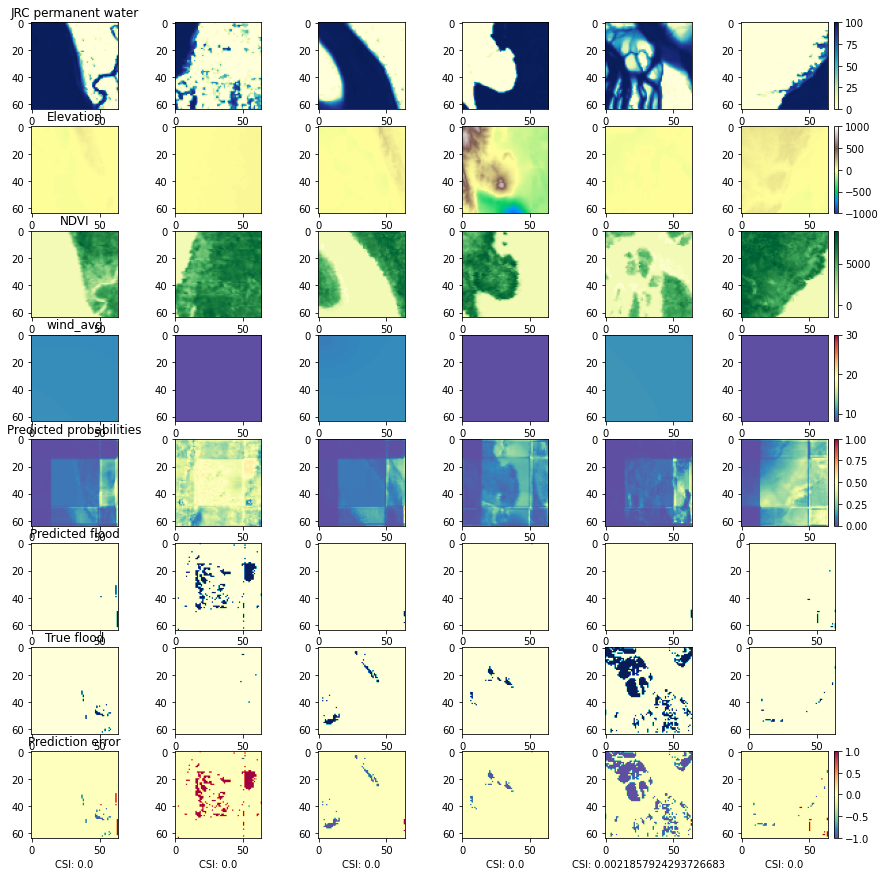

In [16]:
# plot results on the test set
viz = True

if viz:
    fig, axs = plt.subplots(8, len(X_test), figsize=(15, 15))

    ax = axs[0, :]
    for i, pred in enumerate(X_test):
        fi = feature_key_r['jrc_permwa']
        cmap, _, _ = viz_utils.cmap_key['jrc_permwa']
        vmin, vmax = viz_utils.cmap_range['jrc_permwa']
        im = ax[i].imshow(pred[:, :, fi], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0].set_title("JRC permanent water")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    ax = axs[1, :]
    for i, pred in enumerate(X_test):
        fi = feature_key_r['elevation']
        cmap, _, _ = viz_utils.cmap_key['elevation']
        vmin, vmax = viz_utils.cmap_range['elevation']
        im = ax[i].imshow(pred[:, :, fi], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0].set_title("Elevation")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    ax = axs[2, :]
    for i, pred in enumerate(X_test):
        fi = feature_key_r['ndvi']
        cmap, _, _ = viz_utils.cmap_key['ndvi']
        vmin, vmax = viz_utils.cmap_range['ndvi']
        im = ax[i].imshow(pred[:, :, fi], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0].set_title("NDVI")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    
    ax = axs[3, :]
    for i, pred in enumerate(X_test):
        wind_var = 'T' if temporal else 'wind_avg'
        fi = feature_key_r[wind_var]
        cmap, _, _ = viz_utils.cmap_key[wind_var]
        vmin, vmax = viz_utils.cmap_range[wind_var]
        im = ax[i].imshow(pred[:, :, fi], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0].set_title(wind_var)
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    ax = axs[4, :]
    for i, pred in enumerate(y_probs):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="Spectral_r", vmin=0, vmax=1)
    ax[0].set_title("Predicted probabilities")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    ax = axs[5, :]
    for i, pred in enumerate(y_pred):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="YlGnBu", vmin=0, vmax=1)
    ax[0].set_title("Predicted flood")
        
    ax = axs[6, :]
    for i, pred in enumerate(y_test):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="YlGnBu", vmin=0, vmax=1)
    ax[0].set_title("True flood")
    
    ax = axs[7, :]
    for i, x in enumerate(zip(y_pred, y_test)):
        pred, true = x[0], x[1]
        CSI.reset_state()
        CSI.update_state(true, pred)
        csi_i = CSI.result().numpy()
        
        err = (pred.reshape(64, 64) == true.reshape(64, 64)).astype(float)
        diff = pred.reshape(64, 64) - true.reshape(64, 64)
        
        im = ax[i].imshow(diff, cmap="Spectral_r", vmin=-1, vmax=1)
        ax[i].set_xlabel(f"CSI: {csi_i}")
    ax[0].set_title("Prediction error")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    if temporal:
        outfile = join(imdir, "scnn", "scnn_results_temporal.png")
    else:
        outfile = join(imdir, "scnn", "scnn_results.png")
                     
    fig.savefig(outfile, bbox_inches="tight")

In [17]:
# log results
logger.info("NEW RUN")
logger.info(f"Loading data with:\ntemporal={temporal},\nbinary={binary},\nstorm subset: {storm}")
logger.info(f"Run with {nfeatures} features: {features}")
logger.info(f"Number of unique images/subregions: {n}")
logger.info(f"Zeros: {n0}")
logger.info(f"Ones: {n1}")


logger.info(f"Training size: {len(X_train)}")
logger.info(f"Validation size: {len(X_valid)}")
logger.info(f"Test size: {len(X_test)}\n")


logger.info("SCNN SETTINGS")
logger.info(f"Kernel initializer: {k_init}")
logger.info(f"Dilation rate: {dilation_rate}")
logger.info(f"Dry weight: {weights_list[0]}, Wet weight: {weights_list[1]}")
logger.info(f"Weighting function: {weight_func}")
logger.info(f"Optimizer: {optimizer}")
logger.info(f"Loss function: {loss.name}")
logger.info(f"Random seed: {SEED}")
logger.info(f"Number of training epochs: {epochs}")
logger.info(f"Early stopping patience: {patience}\n")

logger.info("RESULTS")
logger.info(f"CSI: {csi * 100:.2f}%")
logger.info(f"TP: {tp:.0f}")
logger.info(f"FP: {fp:.0f}")
logger.info(f"FN: {fn:.0f}")
logger.info(f"TN: {tn:.0f}")

logger.info(f"Bias: {(tp + fp) / (tp + fn) :.2f}")  # small=>underprediction
logger.info(f"Hit rate: {tp /(tp + fn):.2f}")
logger.info(f"False alarm rate: {fp / (fp + tn):.2f}")
logger.info(f"F<3>: {(tp - fn) / (tp + fp + fn):.2f}")

logger.info("END OF RUN\n\n\n")

# U-Net
## _Needs tidying to be same as SCNN above_
[Keras implementation from here](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/)

In [26]:
# define the U-Net architecture
def double_conv_block(x, depth, k_init):
    x = Conv2D(depth, (3, 3), padding="same", activation="relu", kernel_initializer=k_init)(x)
    x = Conv2D(depth, (3, 3), padding="same", activation="relu", kernel_initializer=k_init)(x)
    return x

def downsample_block(x, depth, k_init):
    f = double_conv_block(x, depth, k_init)
    p = MaxPooling2D(2)(f)
    p = Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, depth, k_init):
    x = Conv2DTranspose(depth, 3, 2, padding="same")(x)
    x = concatenate([x, conv_features])
    x = Dropout(0.3)(x)
    x = double_conv_block(x, depth, k_init)
    return x

# compile model using the functional API
def build_unet(shape=(128, 128, 3), k_init="he_normal"):
    inputs = Input(shape=shape)
    normalized = BatchNormalization(axis=3)(inputs)
    
    # encoder
    f1, p1 = downsample_block(normalized, 64, k_init)
    f2, p2 = downsample_block(p1, 128, k_init)
    f3, p3 = downsample_block(p2, 256, k_init)
    f4, p4 = downsample_block(p3, 512, k_init)
    
    # bottleneck
    bottleneck = double_conv_block(p4, 1024, k_init)
    
    # decoder
    u6 = upsample_block(bottleneck, f4, 512, k_init)
    u7 = upsample_block(u6, f3, 256, k_init)
    u8 = upsample_block(u7, f2, 128, k_init)
    u9 = upsample_block(u8, f1, 64, k_init)
    
    # outputs
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(u9)
    outputs = Reshape((64*64, 1))(outputs)
    unet = Model(inputs, outputs, name="U-Net")
    return unet

In [27]:
unet = build_unet(shape=(64, 64, len(features)), k_init="he_normal")

unet.compile(optimizer=SGD(1e-3),
             loss=BinaryCrossentropy(from_logits=True),
             metrics=['accuracy', 'Recall', 'Precision'],
             weighted_metrics=['accuracy', 'Recall', 'Precision'],
             sample_weight_mode='temporal')

history = unet.fit(train.map(add_sample_weights),
                   epochs=40,
                   validation_data=valid,
                   callbacks=EarlyStopping(patience=3))

plot_history(history, metric='loss')             

Epoch 1/40
 5/18 [=======>......................] - ETA: 3s - loss: 0.0015 - accuracy: 0.6058 - recall: 0.3390 - precision: 0.0025 - weighted_accuracy: 0.3390 - recall_1: 0.3390 - precision_1: 1.0000                   

KeyboardInterrupt: 


Testing set root mean squared error: 0.12


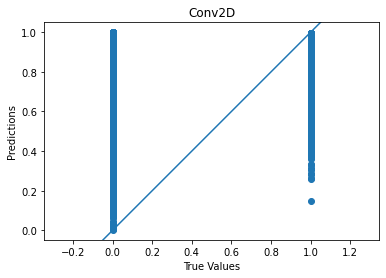

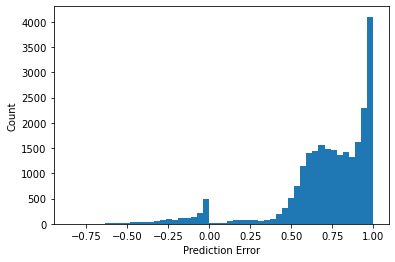

In [43]:
[loss, rmse] = unet.evaluate(test, verbose=0)[:2]
print("\nTesting set root mean squared error: {:4.2f}".format(rmse))

y_probs = unet.predict(test)
y_pred = (y_probs > 0.5).astype(float)

plot_prediction(np.array(y_test).flatten(), y_probs.flatten(), "Conv2D")

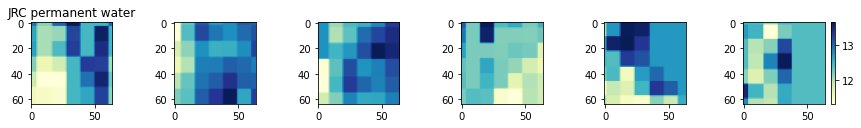

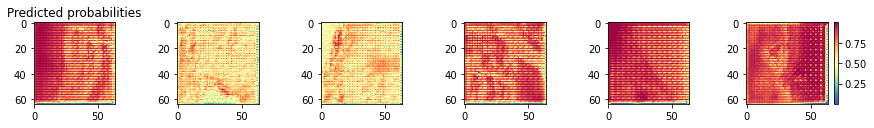

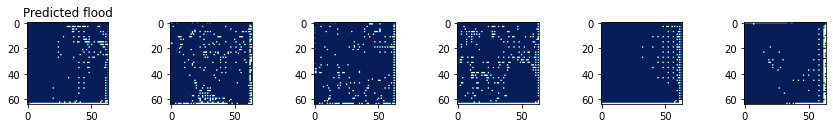

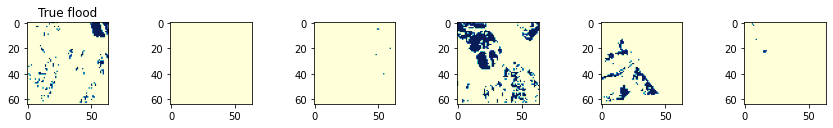

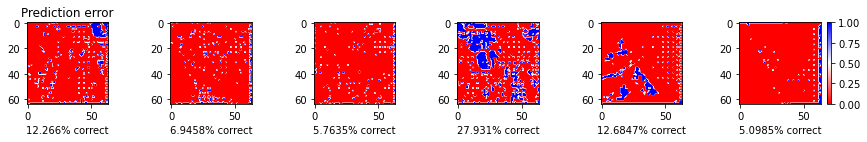

In [44]:
if viz:
    fig, ax = plt.subplots(1, len(X_test), figsize=(15, 1.5))
    for i, pred in enumerate(X_test):
        im = ax[i].imshow(pred[:, :, 2], cmap="YlGnBu")
    ax[0].set_title("JRC permanent water")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    fig, ax = plt.subplots(1, len(y_probs), figsize=(15, 1.5))
    for i, pred in enumerate(y_probs):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="Spectral_r")
    ax[0].set_title("Predicted probabilities")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    fig, ax = plt.subplots(1, len(y_pred), figsize=(15, 1.5))
    for i, pred in enumerate(y_pred):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="YlGnBu")
    ax[0].set_title("Predicted flood")
        
    fig, ax = plt.subplots(1, len(y_test), figsize=(15, 1.5))
    for i, pred in enumerate(y_test):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="YlGnBu")
    ax[0].set_title("True flood")
    
    fig, ax = plt.subplots(1, len(y_pred), figsize=(15, 1.5))
    for i, x in enumerate(zip(y_pred, y_test)):
        pred, true = x[0], x[1]
        err = (pred.reshape(64, 64)==true.reshape(64, 64)).astype(float)
        im = ax[i].imshow(err, cmap="bwr_r")
        ax[i].set_xlabel(f"{np.round(100 * err.sum() / 4060, 4)}% correct")
    ax[0].set_title("Prediction error")
    
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    plt.savefig(join(wd, "unet_results.png"), bbox_inches="tight")

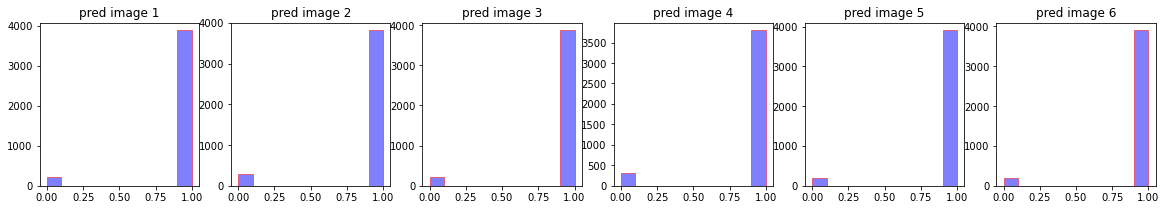

In [45]:
fig, ax = plt.subplots(1, len(y_test), figsize=(20, 3))

for i, _ in enumerate(y_test):
    ax[i].hist(y_pred[i], alpha=0.5, edgecolor="red", color="blue")
    ax[i].set_title(f"pred image {i+1}")